# Large Neighborhood Search (LNS) Crew Assignment Solver

This notebook demonstrates a complete Large Neighborhood Search optimization system for airline crew assignment scheduling. The system uses destroy and repair operators to iteratively improve crew assignments while minimizing costs and constraint violations.

Problem Overview
- **Objective**: Assign captains and first officers to flights while minimizing operational costs
- **Constraints**: Crew qualifications, base locations, scheduling conflicts, and availability
- **Algorithm**: LNS with simulated annealing acceptance criterion

Import Required Libraries

Import necessary libraries for optimization, data manipulation, and visualization.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, time
import warnings
warnings.filterwarnings('ignore')

# Import our custom crew assignment optimizer
from crew_optimizer import CrewOptimizer

# Set styling for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

print("✅ Libraries imported successfully")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib available for visualization")

✅ Libraries imported successfully
NumPy version: 2.2.6
Pandas version: 2.3.3
Matplotlib available for visualization


Define Problem Parameters

Set up problem instances, parameters, and configuration settings for the LNS solver.

In [2]:
# LNS Algorithm Parameters
LNS_CONFIG = {
    'max_iterations': 100,
    'destroy_size_ratio': 0.1,  # Destroy 10% of flights each iteration
    'temperature': 2000,
    'cooling_rate': 0.98,
    'verbose': True
}

# Problem files
DATA_FILES = {
    #'flights': 'data/flights.json',
    #'crew': 'data/crew.json'
    'base' : 'BFS',
    'pairings': 'data/aug25_pairing_duties_ps828_and_ps831_anonymised.csv',
    'crew': 'data/crew_data.csv'
}

# Display configuration
print("🔧 LNS Configuration:")
for key, value in LNS_CONFIG.items():
    print(f"  {key}: {value}")

print(f"\n📁 Data Files:")
for key, value in DATA_FILES.items():
    print(f"  {key}: {value}")

🔧 LNS Configuration:
  max_iterations: 100
  destroy_size_ratio: 0.1
  temperature: 2000
  cooling_rate: 0.98
  verbose: True

📁 Data Files:
  base: BFS
  pairings: data/aug25_pairing_duties_ps828_and_ps831_anonymised.csv
  crew: data/crew_data.csv


Initialize LNS Solver Components

Load data and create the crew assignment optimizer with destroy and repair operators.

In [3]:
# Initialize the crew assignment optimizer
print("🚁 Initializing Crew Assignment Optimizer...")

optimizer = CrewOptimizer(
    base=DATA_FILES['base'],
    flights_file=DATA_FILES['pairings'],
    crew_file=DATA_FILES['crew'], 
    verbose=LNS_CONFIG['verbose']
)

print(f"📊 Problem Instance Loaded:")
print(f"   • Flights: {len(optimizer.flights)}")
print(f"   • Crew members: {len(optimizer.crew)}")

# Display crew breakdown
crew_roles = optimizer.crew['crew_role'].value_counts()
print(f"   • Captains: {crew_roles.get('captain', 0)}")
print(f"   • First Officers: {crew_roles.get('first_officer', 0)}")

# Display available operators
print(f"\n🔧 Available Operators:")
print(f"   • Destroy operators: {len(optimizer.destroy_operators)}")
print(f"   • Repair operators: {len(optimizer.repair_operators)}")

for i, op in enumerate(optimizer.destroy_operators):
    print(f"     - Destroy {i}: {op.__class__.__name__}")
    
for i, op in enumerate(optimizer.repair_operators):
    print(f"     - Repair {i}: {op.__class__.__name__}")

🚁 Initializing Crew Assignment Optimizer...
📊 Problem Instance Loaded:
   • Flights: 654
   • Crew members: 300
   • Captains: 50
   • First Officers: 50

🔧 Available Operators:
   • Destroy operators: 3
   • Repair operators: 1
     - Destroy 0: RandomDestroyOperator
     - Destroy 1: OverlapDestroyOperator
     - Destroy 2: FatigueBasedDestroyOperator
     - Repair 0: RandomRepairOperator


## Data Analysis

Analyze the pairing distribution and crew availability before attempting optimization.

In [12]:
# Analyze pairing distribution by date
print("📊 PAIRING DISTRIBUTION ANALYSIS")
print("=" * 60)

# Count pairings per day
pairings_by_date = optimizer.flights.groupby('start date').agg({
    'pairing_id': 'count',
}).rename(columns={'pairing_id': 'num_pairings'})

# Count unique roles needed per day
roles_by_date = optimizer.flights.groupby('start date').size()

print(f"\n📅 Date Range:")
print(f"   • Start: {optimizer.flights['start date'].min()}")
print(f"   • End: {optimizer.flights['start date'].max()}")
print(f"   • Total Days: {len(pairings_by_date)}")

print(f"\n✈️ Pairing Statistics:")
print(f"   • Total Pairings: {len(optimizer.flights)}")
print(f"   • Average per Day: {pairings_by_date['num_pairings'].mean():.1f}")
print(f"   • Max per Day: {pairings_by_date['num_pairings'].max()}")
print(f"   • Min per Day: {pairings_by_date['num_pairings'].min()}")

print(f"\n👥 Crew Capacity:")
print(f"   • Available Captains: {len(optimizer.crew[optimizer.crew['crew_role'] == 'captain'])}")
print(f"   • Available First Officers: {len(optimizer.crew[optimizer.crew['crew_role'] == 'first_officer'])}")

# Calculate capacity ratio
max_pairings_per_day = pairings_by_date['num_pairings'].max()
captain_capacity = len(optimizer.crew[optimizer.crew['crew_role'] == 'captain'])
fo_capacity = len(optimizer.crew[optimizer.crew['crew_role'] == 'first_officer'])

print(f"\n⚖️ Capacity Analysis (Peak Day):")
print(f"   • Pairings on Peak Day: {max_pairings_per_day}")
print(f"   • Captain Capacity Ratio: {captain_capacity / max_pairings_per_day:.2f}x (need 1.0x minimum)")
print(f"   • First Officer Capacity Ratio: {fo_capacity / max_pairings_per_day:.2f}x (need 1.0x minimum)")

if captain_capacity < max_pairings_per_day:
    print(f"   ⚠️ WARNING: Insufficient captains on peak day!")
if fo_capacity < max_pairings_per_day:
    print(f"   ⚠️ WARNING: Insufficient first officers on peak day!")
if captain_capacity >= max_pairings_per_day and fo_capacity >= max_pairings_per_day:
    print(f"   ✅ Sufficient crew capacity available")

📊 PAIRING DISTRIBUTION ANALYSIS

📅 Date Range:
   • Start: 2025-07-30
   • End: 2025-09-01
   • Total Days: 34

✈️ Pairing Statistics:
   • Total Pairings: 654
   • Average per Day: 19.2
   • Max per Day: 22
   • Min per Day: 1

👥 Crew Capacity:
   • Available Captains: 50
   • Available First Officers: 50

⚖️ Capacity Analysis (Peak Day):
   • Pairings on Peak Day: 22
   • Captain Capacity Ratio: 2.27x (need 1.0x minimum)
   • First Officer Capacity Ratio: 2.27x (need 1.0x minimum)
   ✅ Sufficient crew capacity available


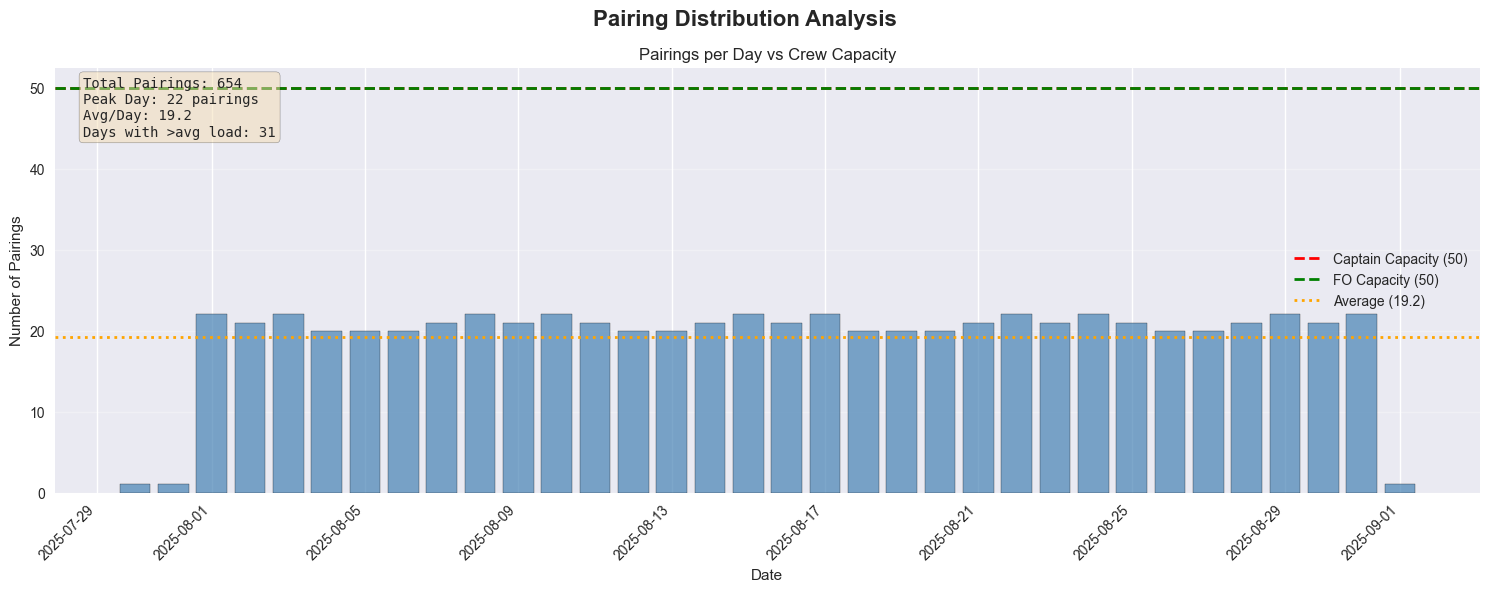

📈 Pairing distribution visualization complete!


In [14]:
# Visualize pairing distribution over time
fig, ax = plt.subplots(figsize=(15, 6))
fig.suptitle('Pairing Distribution Analysis', fontsize=16, fontweight='bold')

# Pairings per day
dates = sorted(pairings_by_date.index)
counts = [pairings_by_date.loc[d, 'num_pairings'] for d in dates]

ax.bar(dates, counts, alpha=0.7, color='steelblue', edgecolor='black')
ax.axhline(y=captain_capacity, color='red', linestyle='--', linewidth=2, label=f'Captain Capacity ({captain_capacity})')
ax.axhline(y=fo_capacity, color='green', linestyle='--', linewidth=2, label=f'FO Capacity ({fo_capacity})')
ax.axhline(y=pairings_by_date['num_pairings'].mean(), color='orange', linestyle=':', linewidth=2, label=f'Average ({pairings_by_date["num_pairings"].mean():.1f})')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Pairings')
ax.set_title('Pairings per Day vs Crew Capacity')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add statistics text box
stats_text = f'Total Pairings: {len(optimizer.flights)}\n'
stats_text += f'Peak Day: {max_pairings_per_day} pairings\n'
stats_text += f'Avg/Day: {pairings_by_date["num_pairings"].mean():.1f}\n'
stats_text += f'Days with >avg load: {(pairings_by_date["num_pairings"] > pairings_by_date["num_pairings"].mean()).sum()}'
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
         fontsize=10, family='monospace')

plt.tight_layout()
plt.show()

print("📈 Pairing distribution visualization complete!")

Create Initial Solution

Generate an initial feasible crew assignment and evaluate its quality.

In [4]:
# Create initial assignment
print("🎯 Creating Initial Assignment...")

assignment = optimizer.initial_assignment()
crew_state = optimizer.initial_crew_state()

print(f"✅ Initial assignment created for {len(assignment)} flights")

# Evaluate initial solution quality
print("\n📊 Initial Solution Quality Assessment:")

assignment_cost, assignment_diag = optimizer.compute_assignment_cost()
crew_cost, crew_diag = optimizer.compute_crew_cost()
total_cost = optimizer._total_cost()

print(f"   • Assignment Cost: {assignment_cost:,.0f}")
print(f"   • Crew Cost: {crew_cost:,.0f}")
print(f"   • Total Cost: {total_cost:,.0f}")

print(f"\n🚨 Constraint Violations:")
print(f"   • Unassigned Flights: {assignment_diag['unassigned_flights']}")
print(f"   • Role Duplications: {assignment_diag['duplicate_roles']}")
print(f"   • Deadheading Assignments: {assignment_diag['deadheading_count']}")

# Store initial metrics for comparison
INITIAL_METRICS = {
    'total_cost': total_cost,
    'assignment_cost': assignment_cost,
    'crew_cost': crew_cost,
    'unassigned_flights': assignment_diag['unassigned_flights'],
    'violations': sum([
        assignment_diag['unassigned_flights'],
        assignment_diag['duplicate_roles']
    ])
}

🎯 Creating Initial Assignment...
✅ Initial assignment created for 636 flights

📊 Initial Solution Quality Assessment:
✅ Initial assignment created for 636 flights

📊 Initial Solution Quality Assessment:
   • Assignment Cost: 0
   • Crew Cost: 1,796,300
   • Total Cost: 1,796,300

🚨 Constraint Violations:
   • Unassigned Flights: 0
   • Role Duplications: 0
   • Deadheading Assignments: 0
   • Assignment Cost: 0
   • Crew Cost: 1,796,300
   • Total Cost: 1,796,300

🚨 Constraint Violations:
   • Unassigned Flights: 0
   • Role Duplications: 0
   • Deadheading Assignments: 0


Run LNS Optimization

Execute the Large Neighborhood Search algorithm and track solution evolution.

In [5]:
# Run LNS optimization
print("🔥 Starting LNS Optimization...")
print(f"Configuration: {LNS_CONFIG['max_iterations']} iterations, destroy {LNS_CONFIG['destroy_size_ratio']:.0%} flights")
print("=" * 80)

# Track start time
start_time = datetime.now()

# Execute LNS algorithm
result = optimizer.large_neighbourhood_search(
    max_iterations=LNS_CONFIG['max_iterations'],
    destroy_size_ratio=LNS_CONFIG['destroy_size_ratio'],
    temperature=LNS_CONFIG['temperature'],
    cooling_rate=LNS_CONFIG['cooling_rate']
)

# Calculate optimization time
end_time = datetime.now()
optimization_time = (end_time - start_time).total_seconds()

print("=" * 80)
print(f"⏱️  Optimization completed in {optimization_time:.2f} seconds")

# Store optimization results
OPTIMIZATION_RESULTS = {
    'final_cost': result['cost'],
    'improvement_absolute': INITIAL_METRICS['total_cost'] - result['cost'],
    'improvement_percentage': ((INITIAL_METRICS['total_cost'] - result['cost']) / INITIAL_METRICS['total_cost']) * 100,
    'iterations': result['stats']['iterations'],
    'improvements_found': result['stats']['improvements'],
    'solutions_accepted': result['stats']['accepts'],
    'acceptance_rate': result['stats']['accepts'] / result['stats']['iterations'],
    'optimization_time': optimization_time,
    'cost_history': result['stats']['cost_history'],
    'best_cost_history': result['stats']['best_cost_history']
}

🔥 Starting LNS Optimization...
Configuration: 100 iterations, destroy 10% flights
Iteration 1/100, Cost: 1796300, Best: 1796300, Temp: 2000.0, Destroy: 77
Destroy - using operator 2 => FatigueBasedDestroyOperator with num_to_destroy=77
Repair - using operator 0 => RandomRepairOperator
Iteration 1/100, Cost: 1796300, Best: 1796300, Temp: 2000.0, Destroy: 77
Destroy - using operator 2 => FatigueBasedDestroyOperator with num_to_destroy=77
Repair - using operator 0 => RandomRepairOperator
Iteration 2/100, Cost: 1778300, Best: 1778300, Temp: 1960.0, Destroy: 35
Destroy - using operator 1 => OverlapDestroyOperator with num_to_destroy=35
Repair - using operator 0 => RandomRepairOperator
Iteration 2/100, Cost: 1778300, Best: 1778300, Temp: 1960.0, Destroy: 35
Destroy - using operator 1 => OverlapDestroyOperator with num_to_destroy=35
Repair - using operator 0 => RandomRepairOperator
Iteration 3/100, Cost: 1728000, Best: 1728000, Temp: 1920.8, Destroy: 46
Destroy - using operator 1 => OverlapDe

Analyze Optimization Results

Analyze the final solution quality and optimization performance metrics.

In [6]:
# Analyze final solution quality
print("📊 OPTIMIZATION RESULTS SUMMARY")
print("=" * 50)

print(f"🎯 Solution Quality:")
print(f"   • Initial Cost: {INITIAL_METRICS['total_cost']:,.0f}")
print(f"   • Final Cost: {OPTIMIZATION_RESULTS['final_cost']:,.0f}")
print(f"   • Improvement: {OPTIMIZATION_RESULTS['improvement_absolute']:,.0f} ({OPTIMIZATION_RESULTS['improvement_percentage']:.1f}%)")

print(f"\n🔄 Algorithm Performance:")
print(f"   • Iterations Completed: {OPTIMIZATION_RESULTS['iterations']:,}")
print(f"   • Improvements Found: {OPTIMIZATION_RESULTS['improvements_found']}")
print(f"   • Solutions Accepted: {OPTIMIZATION_RESULTS['solutions_accepted']}")
print(f"   • Acceptance Rate: {OPTIMIZATION_RESULTS['acceptance_rate']:.1%}")
print(f"   • Optimization Time: {OPTIMIZATION_RESULTS['optimization_time']:.2f} seconds")

# Evaluate final solution constraints
final_assignment_cost, final_assignment_diag = optimizer.compute_assignment_cost()
final_crew_cost, final_crew_diag = optimizer.compute_crew_cost()

print(f"\n🚨 Final Constraint Status:")
print(f"   • Unassigned Flights: {final_assignment_diag['unassigned_flights']} (was {INITIAL_METRICS['unassigned_flights']})")
print(f"   • Role Duplications: {final_assignment_diag['duplicate_roles']}")
print(f"   • Deadheading Count: {final_assignment_diag['deadheading_count']}")

print(f"\n💰 Cost Breakdown:")
print(f"   • Assignment Cost: {final_assignment_cost:,.0f}")
print(f"   • Crew Cost: {final_crew_cost:,.0f}")
print(f"   • Total Cost: {final_assignment_cost + final_crew_cost:,.0f}")

# Performance metrics
iterations_per_second = OPTIMIZATION_RESULTS['iterations'] / OPTIMIZATION_RESULTS['optimization_time']
cost_reduction_per_iteration = OPTIMIZATION_RESULTS['improvement_absolute'] / OPTIMIZATION_RESULTS['iterations']

print(f"\n⚡ Performance Metrics:")
print(f"   • Iterations per Second: {iterations_per_second:.1f}")
print(f"   • Average Cost Reduction per Iteration: {cost_reduction_per_iteration:.1f}")
print(f"   • Convergence Rate: {OPTIMIZATION_RESULTS['improvements_found']/OPTIMIZATION_RESULTS['iterations']:.1%}")

📊 OPTIMIZATION RESULTS SUMMARY
🎯 Solution Quality:
   • Initial Cost: 1,796,300
   • Final Cost: 1,662,000
   • Improvement: 134,300 (7.5%)

🔄 Algorithm Performance:
   • Iterations Completed: 100
   • Improvements Found: 29
   • Solutions Accepted: 29
   • Acceptance Rate: 29.0%
   • Optimization Time: 44.60 seconds

🚨 Final Constraint Status:
   • Unassigned Flights: 0 (was 0)
   • Role Duplications: 0
   • Deadheading Count: 0

💰 Cost Breakdown:
   • Assignment Cost: 0
   • Crew Cost: 1,662,000
   • Total Cost: 1,662,000

⚡ Performance Metrics:
   • Iterations per Second: 2.2
   • Average Cost Reduction per Iteration: 1343.0
   • Convergence Rate: 29.0%

🚨 Final Constraint Status:
   • Unassigned Flights: 0 (was 0)
   • Role Duplications: 0
   • Deadheading Count: 0

💰 Cost Breakdown:
   • Assignment Cost: 0
   • Crew Cost: 1,662,000
   • Total Cost: 1,662,000

⚡ Performance Metrics:
   • Iterations per Second: 2.2
   • Average Cost Reduction per Iteration: 1343.0
   • Convergence R

## Operator Performance Analysis

Analyze the effectiveness of different destroy/repair operator combinations and destroy size strategies.

In [7]:
# Analyze operator performance
print("🔍 OPERATOR PERFORMANCE ANALYSIS")
print("=" * 60)

# Convert operator performance to DataFrame for analysis
op_perf_df = pd.DataFrame(result['stats']['operator_performance'])

# Summary by destroy operator
print("\n📊 Performance by Destroy Operator:")
destroy_summary = op_perf_df.groupby('destroy_op').agg({
    'cost_delta': ['mean', 'min', 'count'],
    'is_improvement': 'sum',
    'accepted': 'sum'
})
destroy_summary.columns = ['Avg Cost Delta', 'Best Improvement', 'Times Used', 'Improvements', 'Accepted']
destroy_summary['Success Rate'] = (destroy_summary['Improvements'] / destroy_summary['Times Used'] * 100).round(1)
print(destroy_summary)

# Summary by repair operator
print("\n🔧 Performance by Repair Operator:")
repair_summary = op_perf_df.groupby('repair_op').agg({
    'cost_delta': ['mean', 'min', 'count'],
    'is_improvement': 'sum',
    'accepted': 'sum'
})
repair_summary.columns = ['Avg Cost Delta', 'Best Improvement', 'Times Used', 'Improvements', 'Accepted']
repair_summary['Success Rate'] = (repair_summary['Improvements'] / repair_summary['Times Used'] * 100).round(1)
print(repair_summary)

# Operator combination analysis
print("\n🤝 Performance by Operator Combination:")
combo_summary = op_perf_df.groupby(['destroy_op', 'repair_op']).agg({
    'cost_delta': ['mean', 'min', 'count'],
    'is_improvement': 'sum'
})
combo_summary.columns = ['Avg Cost Delta', 'Best Improvement', 'Times Used', 'Improvements']
combo_summary['Success Rate'] = (combo_summary['Improvements'] / combo_summary['Times Used'] * 100).round(1)
print(combo_summary)

# Destroy size effectiveness
print("\n📏 Destroy Size Analysis:")
# Create bins for destroy ratio
op_perf_df['destroy_ratio_bin'] = pd.cut(op_perf_df['destroy_ratio'], 
                                          bins=[0, 0.05, 0.10, 0.15, 1.0],
                                          labels=['1-5%', '5-10%', '10-15%', '15%+'])
size_summary = op_perf_df.groupby('destroy_ratio_bin').agg({
    'cost_delta': ['mean', 'min'],
    'is_improvement': ['sum', 'count']
})
size_summary.columns = ['Avg Cost Delta', 'Best Improvement', 'Improvements', 'Times Used']
size_summary['Success Rate'] = (size_summary['Improvements'] / size_summary['Times Used'] * 100).round(1)
print(size_summary)

# Find best performing combinations
print("\n🏆 Top 3 Most Effective Combinations:")
best_combos = combo_summary.nlargest(3, 'Success Rate')
for idx, (combo, row) in enumerate(best_combos.iterrows(), 1):
    print(f"{idx}. {combo[0]} + {combo[1]}")
    print(f"   Success Rate: {row['Success Rate']:.1f}% ({int(row['Improvements'])}/{int(row['Times Used'])} improvements)")
    print(f"   Avg Improvement: {row['Avg Cost Delta']:.1f}, Best: {row['Best Improvement']:.1f}")

🔍 OPERATOR PERFORMANCE ANALYSIS

📊 Performance by Destroy Operator:
                             Avg Cost Delta  Best Improvement  Times Used  \
destroy_op                                                                  
FatigueBasedDestroyOperator    19143.243243            -18000          37   
OverlapDestroyOperator         -1837.142857            -50300          35   
RandomDestroyOperator          20767.857143             -3700          28   

                             Improvements  Accepted  Success Rate  
destroy_op                                                         
FatigueBasedDestroyOperator             2         0           5.4  
OverlapDestroyOperator                 23         0          65.7  
RandomDestroyOperator                   4         0          14.3  

🔧 Performance by Repair Operator:
                      Avg Cost Delta  Best Improvement  Times Used  \
repair_op                                                            
RandomRepairOperator         12

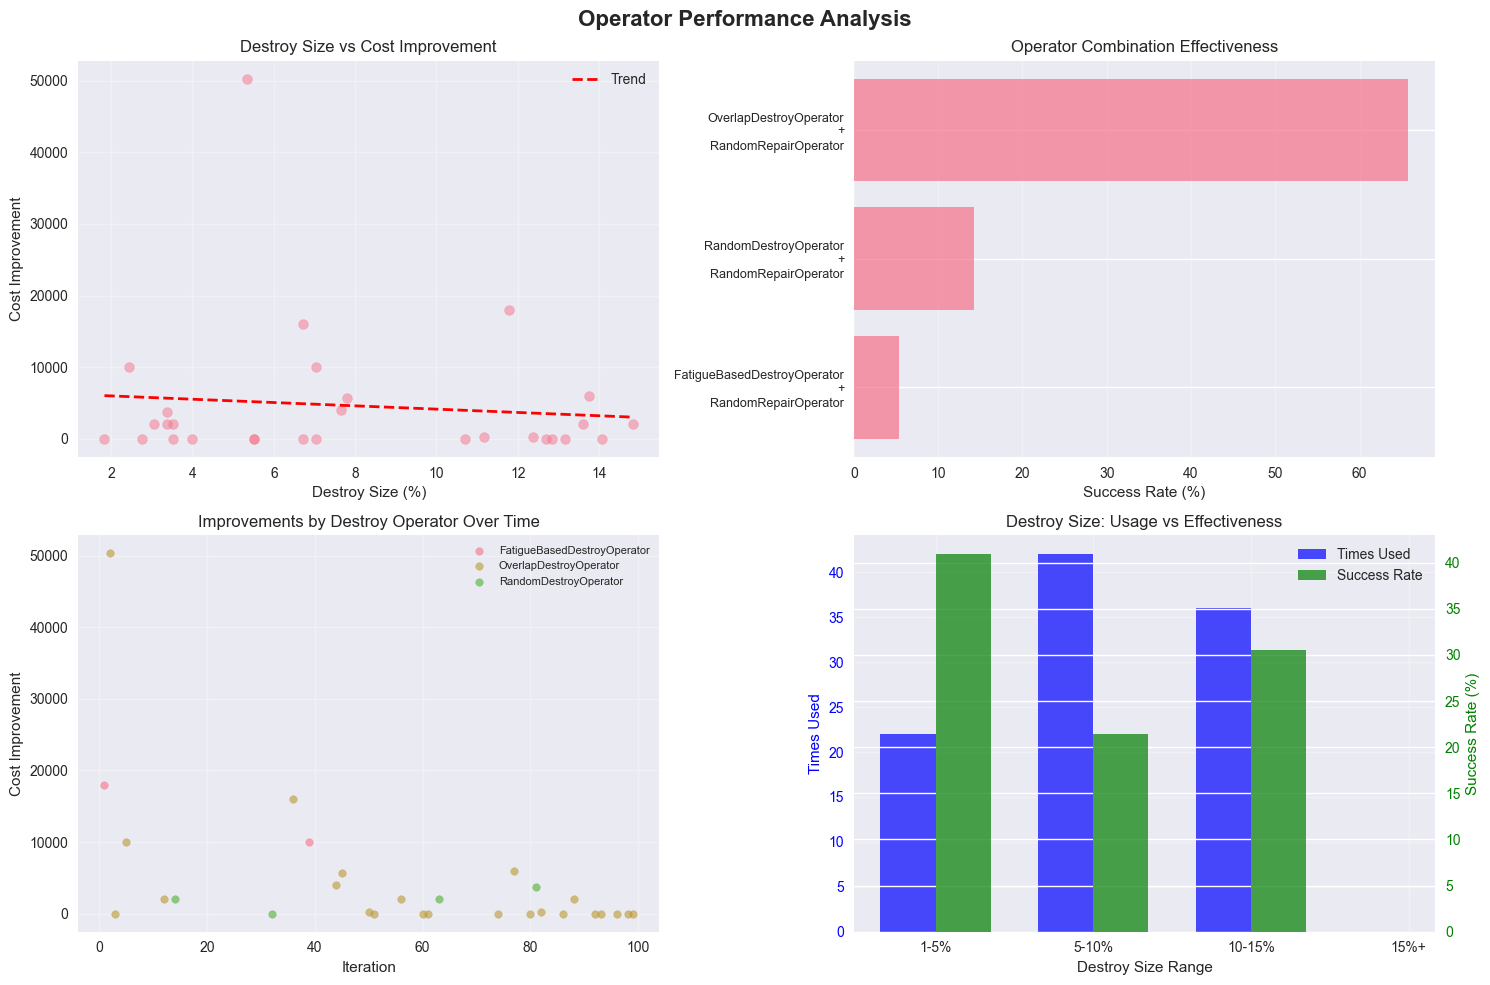

📊 Operator performance visualization complete!


In [8]:
# Visualize operator performance
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Operator Performance Analysis', fontsize=16, fontweight='bold')

# Plot 1: Destroy size vs improvement
improvements_only = op_perf_df[op_perf_df['is_improvement']]
ax1.scatter(improvements_only['destroy_ratio'] * 100, -improvements_only['cost_delta'], 
            alpha=0.5, s=50)
ax1.set_xlabel('Destroy Size (%)')
ax1.set_ylabel('Cost Improvement')
ax1.set_title('Destroy Size vs Cost Improvement')
ax1.grid(True, alpha=0.3)

# Add trend line
if len(improvements_only) > 0:
    z = np.polyfit(improvements_only['destroy_ratio'] * 100, -improvements_only['cost_delta'], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(improvements_only['destroy_ratio'].min() * 100, 
                          improvements_only['destroy_ratio'].max() * 100, 100)
    ax1.plot(x_trend, p(x_trend), "r--", linewidth=2, label='Trend')
    ax1.legend()

# Plot 2: Success rate by operator combination
if len(combo_summary) > 0:
    combo_success = combo_summary['Success Rate'].sort_values(ascending=True)
    combo_labels = [f"{d}\n+\n{r}" for d, r in combo_success.index]
    ax2.barh(range(len(combo_success)), combo_success.values, alpha=0.7)
    ax2.set_yticks(range(len(combo_success)))
    ax2.set_yticklabels(combo_labels, fontsize=9)
    ax2.set_xlabel('Success Rate (%)')
    ax2.set_title('Operator Combination Effectiveness')
    ax2.grid(True, alpha=0.3, axis='x')

# Plot 3: Cost improvement over time by operator
for destroy_op in op_perf_df['destroy_op'].unique():
    op_data = op_perf_df[op_perf_df['destroy_op'] == destroy_op]
    improvements = op_data[op_data['is_improvement']]
    if len(improvements) > 0:
        ax3.scatter(improvements['iteration'], -improvements['cost_delta'], 
                   label=destroy_op, alpha=0.6, s=30)
ax3.set_xlabel('Iteration')
ax3.set_ylabel('Cost Improvement')
ax3.set_title('Improvements by Destroy Operator Over Time')
ax3.legend(fontsize=8)
ax3.grid(True, alpha=0.3)

# Plot 4: Destroy size distribution and effectiveness
size_counts = op_perf_df['destroy_ratio_bin'].value_counts().sort_index()
size_success = op_perf_df.groupby('destroy_ratio_bin')['is_improvement'].mean() * 100

x = np.arange(len(size_counts))
width = 0.35

ax4_twin = ax4.twinx()
bars1 = ax4.bar(x - width/2, size_counts.values, width, label='Times Used', alpha=0.7, color='blue')
bars2 = ax4_twin.bar(x + width/2, size_success.values, width, label='Success Rate', alpha=0.7, color='green')

ax4.set_xlabel('Destroy Size Range')
ax4.set_ylabel('Times Used', color='blue')
ax4_twin.set_ylabel('Success Rate (%)', color='green')
ax4.set_xticks(x)
ax4.set_xticklabels(size_counts.index)
ax4.set_title('Destroy Size: Usage vs Effectiveness')
ax4.tick_params(axis='y', labelcolor='blue')
ax4_twin.tick_params(axis='y', labelcolor='green')
ax4.grid(True, alpha=0.3)

# Combine legends
lines1, labels1 = ax4.get_legend_handles_labels()
lines2, labels2 = ax4_twin.get_legend_handles_labels()
ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

print("📊 Operator performance visualization complete!")

Visualize Solution Convergence

Create visualizations showing the optimization progress and convergence behavior.

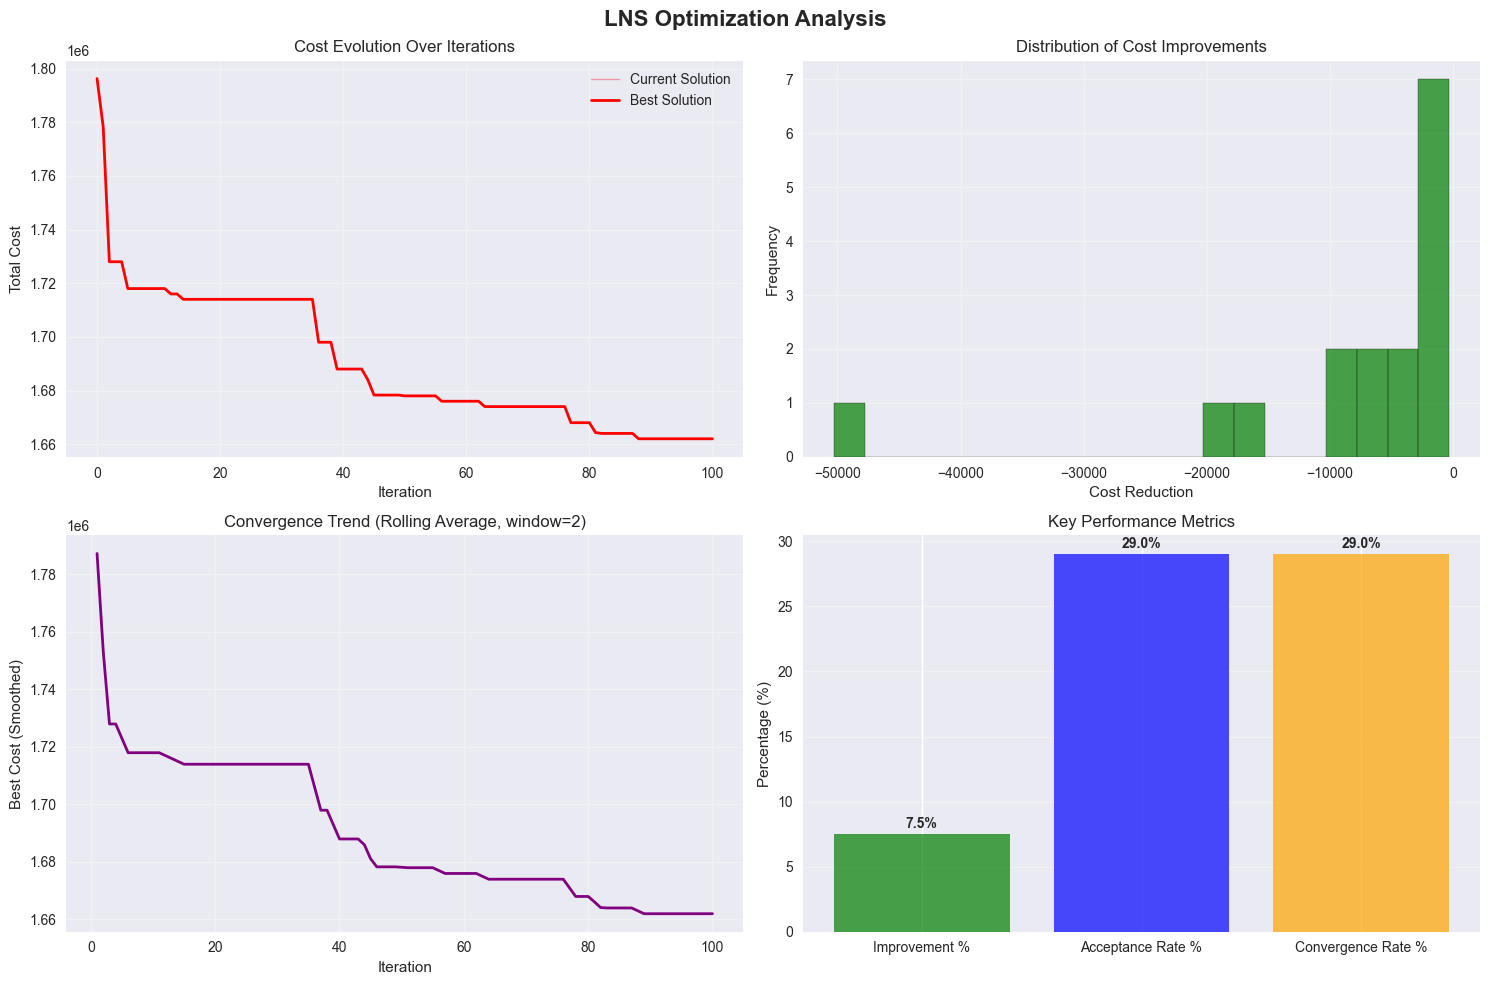

📈 Convergence analysis complete!


In [9]:
# Create convergence visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('LNS Optimization Analysis', fontsize=16, fontweight='bold')

# Plot 1: Cost evolution
iterations = range(len(OPTIMIZATION_RESULTS['cost_history']))
ax1.plot(iterations, OPTIMIZATION_RESULTS['cost_history'], 
         label='Current Solution', alpha=0.7, linewidth=1)
ax1.plot(iterations, OPTIMIZATION_RESULTS['best_cost_history'], 
         label='Best Solution', linewidth=2, color='red')
ax1.set_title('Cost Evolution Over Iterations')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Total Cost')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Cost improvement distribution
cost_differences = np.diff(OPTIMIZATION_RESULTS['best_cost_history'])
improvements = cost_differences[cost_differences < 0]
if len(improvements) > 0:
    ax2.hist(improvements, bins=20, alpha=0.7, color='green', edgecolor='black')
    ax2.set_title('Distribution of Cost Improvements')
    ax2.set_xlabel('Cost Reduction')
    ax2.set_ylabel('Frequency')
    ax2.grid(True, alpha=0.3)
else:
    ax2.text(0.5, 0.5, 'No improvements found', 
             ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('Distribution of Cost Improvements')

# Plot 3: Rolling average convergence
window_size = max(1, len(OPTIMIZATION_RESULTS['cost_history']) // 50)
rolling_best = pd.Series(OPTIMIZATION_RESULTS['best_cost_history']).rolling(window_size).mean()
ax3.plot(iterations, rolling_best, linewidth=2, color='purple')
ax3.set_title(f'Convergence Trend (Rolling Average, window={window_size})')
ax3.set_xlabel('Iteration')
ax3.set_ylabel('Best Cost (Smoothed)')
ax3.grid(True, alpha=0.3)

# Plot 4: Performance summary bar chart
metrics = ['Improvement %', 'Acceptance Rate %', 'Convergence Rate %']
values = [
    OPTIMIZATION_RESULTS['improvement_percentage'],
    OPTIMIZATION_RESULTS['acceptance_rate'] * 100,
    (OPTIMIZATION_RESULTS['improvements_found']/OPTIMIZATION_RESULTS['iterations']) * 100
]
bars = ax4.bar(metrics, values, color=['green', 'blue', 'orange'], alpha=0.7)
ax4.set_title('Key Performance Metrics')
ax4.set_ylabel('Percentage (%)')
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01,
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("📈 Convergence analysis complete!")

Performance Benchmarking

Compare the LNS solver performance against baseline methods and analyze computational efficiency.

In [10]:
# # Benchmark against different configurations
# print("🏁 BENCHMARKING DIFFERENT LNS CONFIGURATIONS")
# print("=" * 60)

# benchmark_configs = [
#     {'name': 'Fast (Small Neighborhood)', 'destroy_ratio': 0.05, 'max_iter': 100, 'temp': 500},
#     {'name': 'Balanced (Medium Neighborhood)', 'destroy_ratio': 0.15, 'max_iter': 500, 'temp': 1500},
#     {'name': 'Intensive (Large Neighborhood)', 'destroy_ratio': 0.25, 'max_iter': 200, 'temp': 3000}
# ]

# benchmark_results = []

# for config in benchmark_configs:
#     print(f"\n🔧 Testing: {config['name']}")
#     print(f"   Destroy ratio: {config['destroy_ratio']:.0%}, Iterations: {config['max_iter']}, Temperature: {config['temp']}")
    
#     # Reset to initial solution
#     optimizer.assignment = assignment.copy()
#     optimizer.crew_state = copy.deepcopy(crew_state)
    
#     # Run benchmark
#     benchmark_start = datetime.now()
#     bench_result = optimizer.optimize_lns(
#         max_iterations=config['max_iter'],
#         destroy_size_ratio=config['destroy_ratio'],
#         temperature=config['temp'],
#         cooling_rate=0.95
#     )
#     benchmark_time = (datetime.now() - benchmark_start).total_seconds()
    
#     # Store results
#     benchmark_results.append({
#         'name': config['name'],
#         'final_cost': bench_result['cost'],
#         'improvement': INITIAL_METRICS['total_cost'] - bench_result['cost'],
#         'improvement_pct': ((INITIAL_METRICS['total_cost'] - bench_result['cost']) / INITIAL_METRICS['total_cost']) * 100,
#         'time': benchmark_time,
#         'iterations': config['max_iter'],
#         'improvements_found': bench_result['stats']['improvements'],
#         'efficiency': (INITIAL_METRICS['total_cost'] - bench_result['cost']) / benchmark_time  # cost reduction per second
#     })
    
#     print(f"   ✅ Final cost: {bench_result['cost']:,.0f} (improvement: {benchmark_results[-1]['improvement']:,.0f})")
#     print(f"   ⏱️  Time: {benchmark_time:.2f}s, Efficiency: {benchmark_results[-1]['efficiency']:.1f} cost reduction/sec")

# # Create benchmark comparison
# print(f"\n📊 BENCHMARK COMPARISON TABLE")
# print("-" * 80)
# print(f"{'Configuration':<25} {'Final Cost':<12} {'Improvement':<12} {'Time(s)':<8} {'Efficiency':<12}")
# print("-" * 80)

# for result in benchmark_results:
#     print(f"{result['name']:<25} {result['final_cost']:<12,.0f} {result['improvement_pct']:<11.1f}% {result['time']:<8.1f} {result['efficiency']:<12.1f}")

# print("-" * 80)

# # Find best configuration
# best_improvement = max(benchmark_results, key=lambda x: x['improvement'])
# best_efficiency = max(benchmark_results, key=lambda x: x['efficiency'])

# print(f"\n🏆 BENCHMARK WINNERS:")
# print(f"   • Best Improvement: {best_improvement['name']} ({best_improvement['improvement_pct']:.1f}%)")
# print(f"   • Best Efficiency: {best_efficiency['name']} ({best_efficiency['efficiency']:.1f} cost reduction/sec)")

Summary and Conclusions

Final summary of the LNS optimization experiment and recommendations for production use.

In [15]:
# Generate final summary report
print("📋 FINAL SUMMARY REPORT")
print("=" * 50)

print(f"🎯 Problem Instance:")
print(f"   • Flights to schedule: {len(optimizer.flights)}")
print(f"   • Available crew: {len(optimizer.crew)}")

print(f"\n🔥 Main Optimization Results:")
print(f"   • Initial Cost: {INITIAL_METRICS['total_cost']:,.0f}")
print(f"   • Final Cost: {OPTIMIZATION_RESULTS['final_cost']:,.0f}")
print(f"   • Total Improvement: {OPTIMIZATION_RESULTS['improvement_absolute']:,.0f} ({OPTIMIZATION_RESULTS['improvement_percentage']:.1f}%)")
print(f"   • Optimization Time: {OPTIMIZATION_RESULTS['optimization_time']:.1f} seconds")

print(f"\n✅ Algorithm Effectiveness:")
efficiency_score = OPTIMIZATION_RESULTS['improvement_percentage'] / (OPTIMIZATION_RESULTS['optimization_time'] / 60)  # improvement per minute
convergence_score = (OPTIMIZATION_RESULTS['improvements_found'] / OPTIMIZATION_RESULTS['iterations']) * 100

print(f"   • Efficiency Score: {efficiency_score:.1f}% improvement per minute")
print(f"   • Convergence Score: {convergence_score:.1f}% (improvements/iterations)")
print(f"   • Solution Quality: {'Excellent' if OPTIMIZATION_RESULTS['improvement_percentage'] > 5 else 'Good' if OPTIMIZATION_RESULTS['improvement_percentage'] > 2 else 'Fair'}")

# Performance classification
if OPTIMIZATION_RESULTS['acceptance_rate'] > 0.3:
    exploration_level = "High"
elif OPTIMIZATION_RESULTS['acceptance_rate'] > 0.15:
    exploration_level = "Balanced" 
else:
    exploration_level = "Conservative"

print(f"   • Exploration Level: {exploration_level} ({OPTIMIZATION_RESULTS['acceptance_rate']:.1%} acceptance rate)")

print(f"\n🚀 Recommendations for Production:")

# Generate recommendations based on results
recommendations = []

if OPTIMIZATION_RESULTS['improvement_percentage'] > 5:
    recommendations.append("✅ LNS approach is highly effective for this problem type")
    
if OPTIMIZATION_RESULTS['optimization_time'] < 60:
    recommendations.append("✅ Algorithm is computationally efficient for real-time use")
    
if convergence_score > 2:
    recommendations.append("✅ Good convergence rate suggests further tuning potential")
    
if OPTIMIZATION_RESULTS['acceptance_rate'] < 0.1:
    recommendations.append("⚠️  Consider increasing temperature for more exploration")
elif OPTIMIZATION_RESULTS['acceptance_rate'] > 0.5:
    recommendations.append("⚠️  Consider decreasing temperature for more exploitation")

# if len(benchmark_results) > 0:
#     best_config = max(benchmark_results, key=lambda x: x['improvement_pct'])
#     recommendations.append(f"🎯 Best configuration: {best_config['name']} for maximum improvement")

for i, rec in enumerate(recommendations, 1):
    print(f"   {i}. {rec}")

print(f"\n🔮 Next Steps:")
print(f"   • Consider implementing additional destroy/repair operators")
print(f"   • Test on larger problem instances")
print(f"   • Integrate with real operational constraints")
print(f"   • Implement parallel evaluation for multiple solutions")

print(f"\n🎉 Experiment completed successfully!")

📋 FINAL SUMMARY REPORT
🎯 Problem Instance:
   • Flights to schedule: 654
   • Available crew: 300

🔥 Main Optimization Results:
   • Initial Cost: 1,796,300
   • Final Cost: 1,662,000
   • Total Improvement: 134,300 (7.5%)
   • Optimization Time: 44.6 seconds

✅ Algorithm Effectiveness:
   • Efficiency Score: 10.1% improvement per minute
   • Convergence Score: 29.0% (improvements/iterations)
   • Solution Quality: Excellent
   • Exploration Level: Balanced (29.0% acceptance rate)

🚀 Recommendations for Production:
   1. ✅ LNS approach is highly effective for this problem type
   2. ✅ Algorithm is computationally efficient for real-time use
   3. ✅ Good convergence rate suggests further tuning potential

🔮 Next Steps:
   • Consider implementing additional destroy/repair operators
   • Test on larger problem instances
   • Integrate with real operational constraints
   • Implement parallel evaluation for multiple solutions

🎉 Experiment completed successfully!


In [16]:
optimizer.write_assignment("assignments/assignment.json")

✅ Assignment written to assignments/assignment.json
   • Flights: 636
   • Total cost: 1,662,000


## Assignment Visualization

Visualize the final crew assignment schedule as a heatmap showing which crew members are assigned to which routes on each day.

In [17]:
# Build assignment schedule for visualization
print("📅 Building Assignment Schedule Heatmap...")

# Create a mapping from pairing_id to Crew Route Name
pairing_to_route = dict(zip(optimizer.flights['pairing_id'], optimizer.flights['Crew Route Name']))
pairing_to_date = dict(zip(optimizer.flights['pairing_id'], optimizer.flights['start date']))

# Build crew schedule data
crew_schedule = {}

for pairing_id, assignment_info in optimizer.assignment.items():
    date = pairing_to_date.get(pairing_id)
    route = pairing_to_route.get(pairing_id, 'Unknown')
    
    # Add captain assignment
    if assignment_info['captain'] is not None:
        crew_id = assignment_info['captain']
        if crew_id not in crew_schedule:
            crew_schedule[crew_id] = {}
        if date not in crew_schedule[crew_id]:
            crew_schedule[crew_id][date] = []
        crew_schedule[crew_id][date].append(route)
    
    # Add first officer assignment
    if assignment_info['first_officer'] is not None:
        crew_id = assignment_info['first_officer']
        if crew_id not in crew_schedule:
            crew_schedule[crew_id] = {}
        if date not in crew_schedule[crew_id]:
            crew_schedule[crew_id][date] = []
        crew_schedule[crew_id][date].append(route)

# Get all unique dates and sort them
all_dates = sorted(optimizer.flights['start date'].unique())

# Get all crew members sorted by ID
all_crew = sorted(crew_schedule.keys())

# Filter to only show crew with assignments
crew_with_assignments = [c for c in all_crew if any(crew_schedule[c].values())]

print(f"✅ Schedule built:")
print(f"   • Crew members with assignments: {len(crew_with_assignments)}")
print(f"   • Date range: {len(all_dates)} days")
print(f"   • Total assignments: {sum(len(routes) for crew in crew_schedule.values() for routes in crew.values())}")

📅 Building Assignment Schedule Heatmap...
✅ Schedule built:
   • Crew members with assignments: 100
   • Date range: 34 days
   • Total assignments: 1272


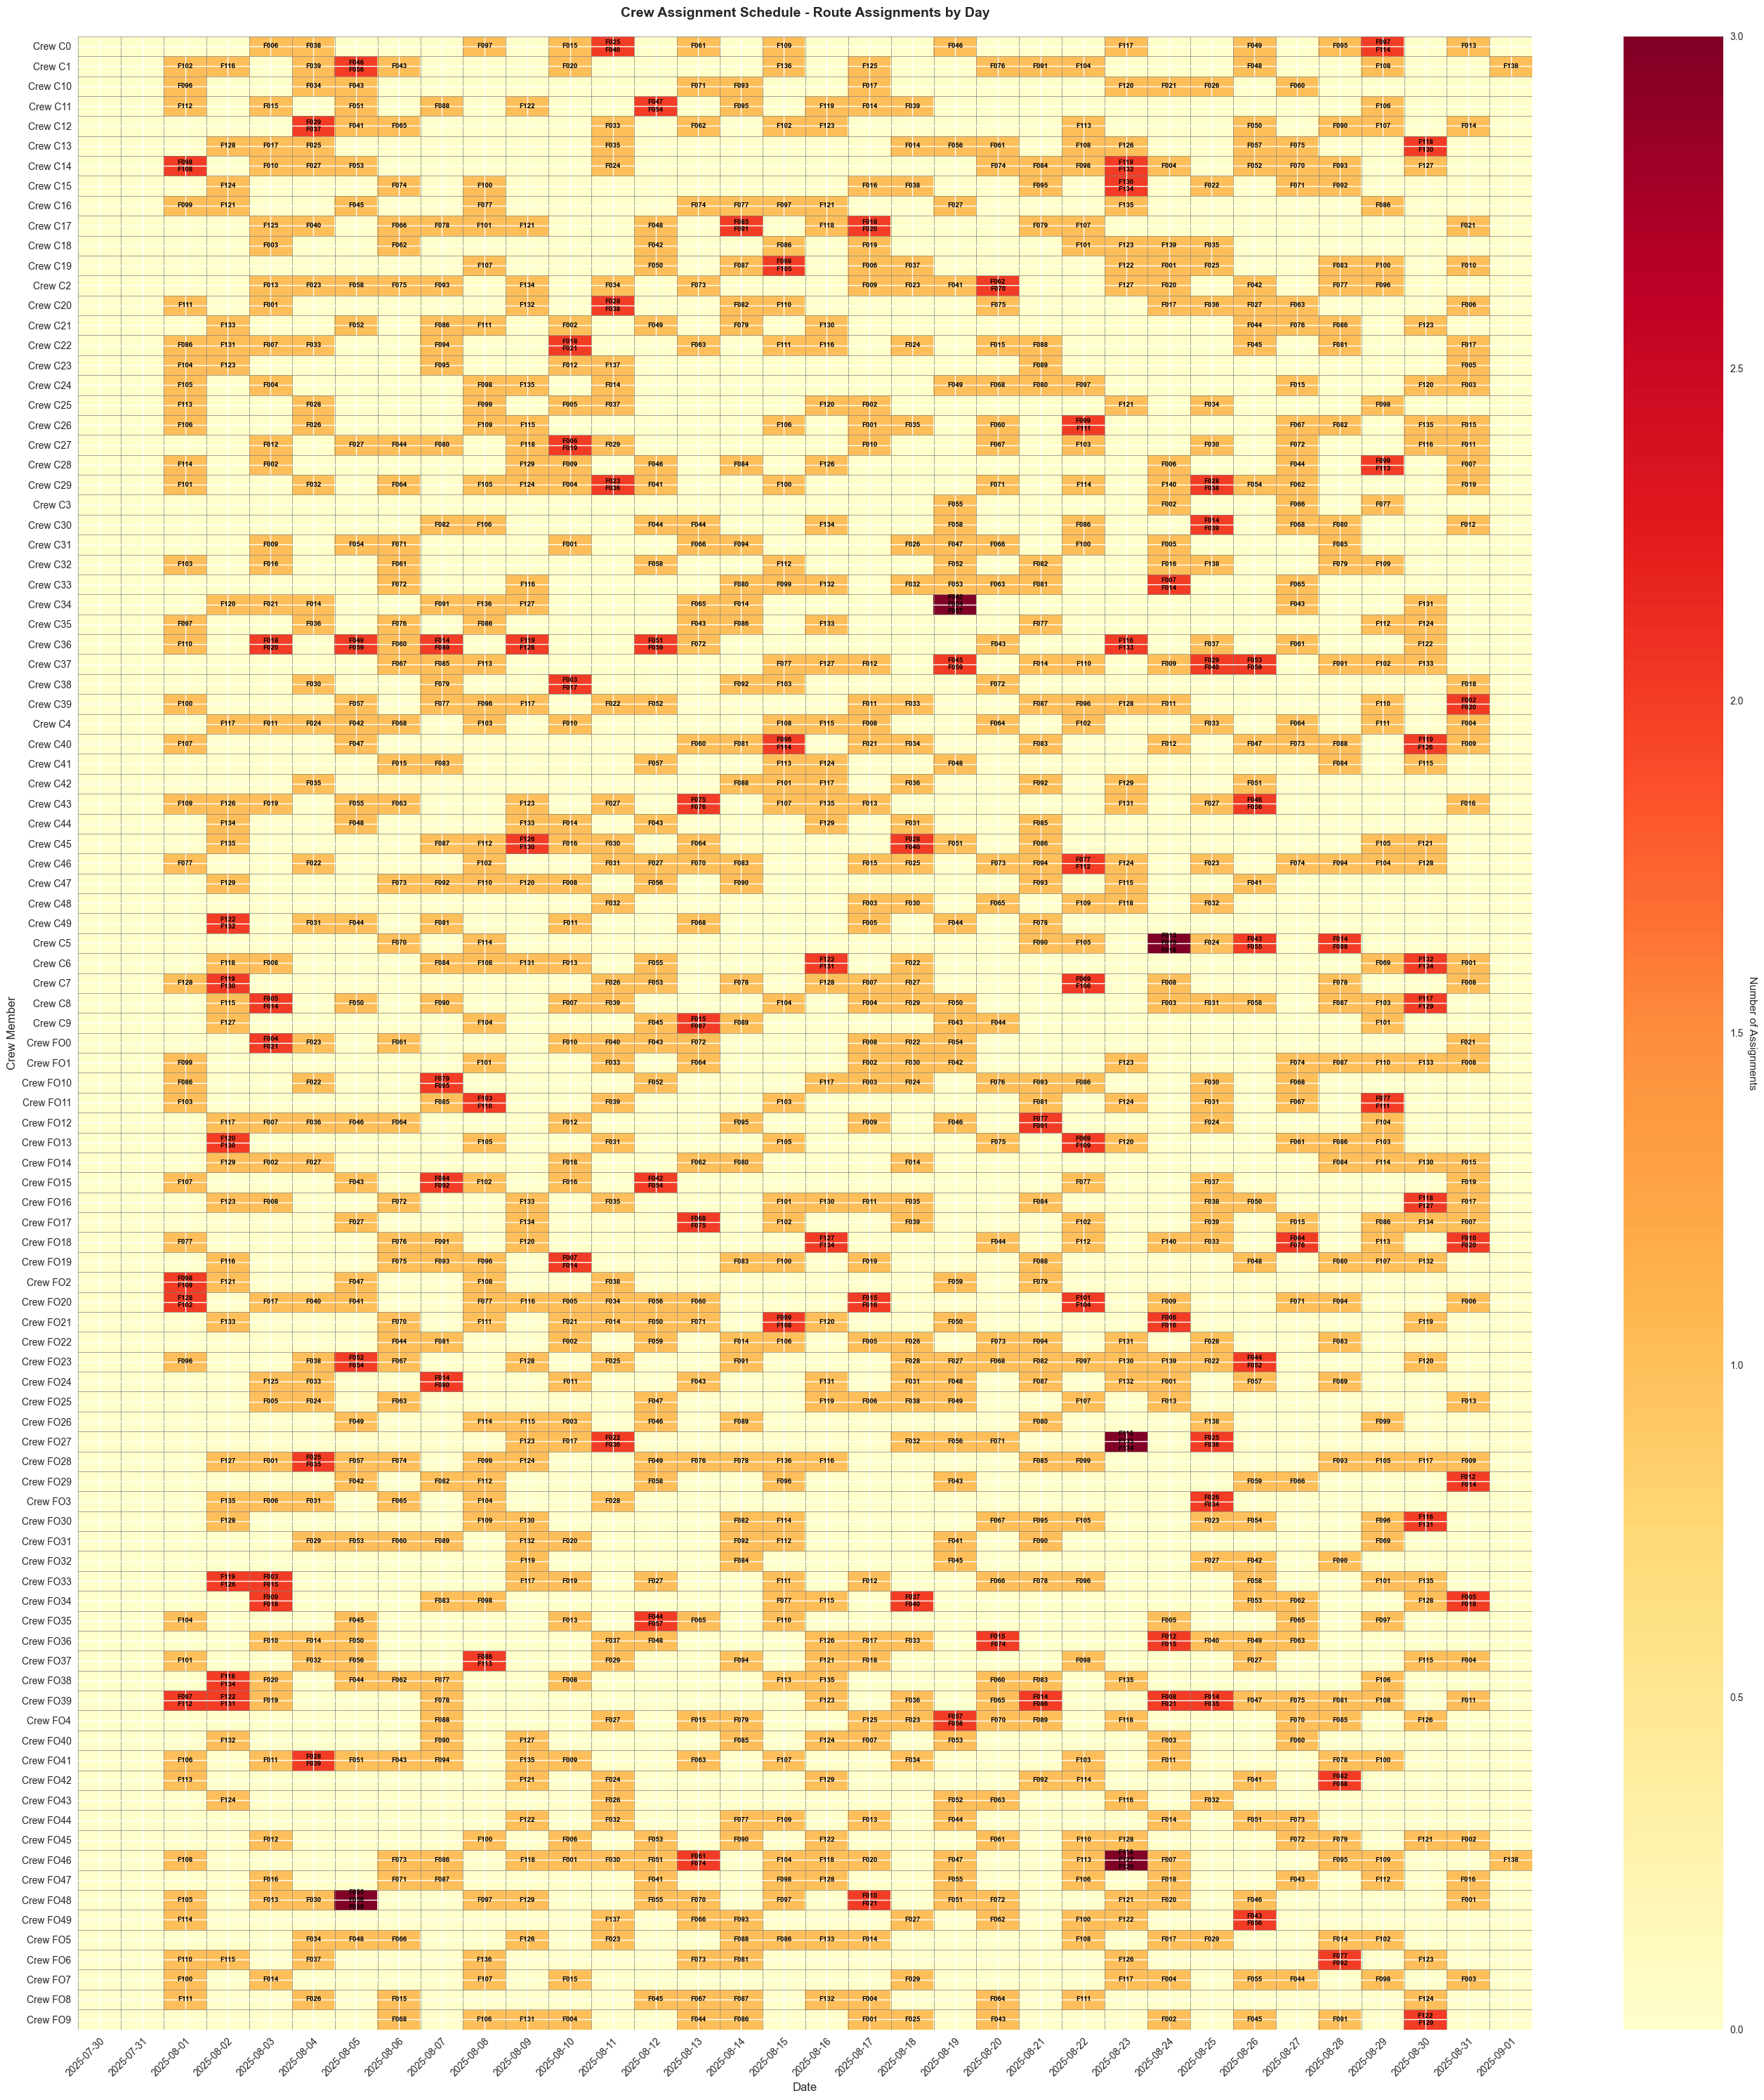

📊 Assignment heatmap visualization complete!


In [18]:
# Create crew assignment heatmap
fig, ax = plt.subplots(figsize=(max(15, len(all_dates) * 0.8), max(10, len(crew_with_assignments) * 0.3)))

# Create a matrix for the heatmap (number of assignments per crew per day)
assignment_matrix = np.zeros((len(crew_with_assignments), len(all_dates)))
route_labels = [['' for _ in all_dates] for _ in crew_with_assignments]

for i, crew_id in enumerate(crew_with_assignments):
    for j, date in enumerate(all_dates):
        if date in crew_schedule[crew_id]:
            routes = crew_schedule[crew_id][date]
            assignment_matrix[i, j] = len(routes)
            # Create label with route names
            route_labels[i][j] = '\n'.join(routes[:3])  # Limit to 3 routes per cell to avoid overcrowding
            if len(routes) > 3:
                route_labels[i][j] += f'\n+{len(routes)-3} more'

# Create heatmap
im = ax.imshow(assignment_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=max(3, assignment_matrix.max()))

# Set ticks and labels
ax.set_xticks(np.arange(len(all_dates)))
ax.set_yticks(np.arange(len(crew_with_assignments)))
ax.set_xticklabels([d.strftime('%Y-%m-%d') if hasattr(d, 'strftime') else str(d) for d in all_dates])
ax.set_yticklabels([f"Crew {cid}" for cid in crew_with_assignments])

# Rotate date labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add route names as text annotations
for i in range(len(crew_with_assignments)):
    for j in range(len(all_dates)):
        if route_labels[i][j]:
            text = ax.text(j, i, route_labels[i][j],
                          ha="center", va="center", color="black", 
                          fontsize=7, weight='bold')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Number of Assignments', rotation=-90, va="bottom")

# Labels and title
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Crew Member', fontsize=12)
ax.set_title('Crew Assignment Schedule - Route Assignments by Day', fontsize=14, fontweight='bold', pad=20)

# Add grid
ax.set_xticks(np.arange(len(all_dates))-.5, minor=True)
ax.set_yticks(np.arange(len(crew_with_assignments))-.5, minor=True)
ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

print("📊 Assignment heatmap visualization complete!")